In [4]:
# Clone the dataset repository
!git clone https://github.com/hailynaduna/autonomous-driving-dataset

fatal: destination path 'autonomous-driving-dataset' already exists and is not an empty directory.


Training Fold 1...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3953 - loss: 1.1078 - val_accuracy: 0.5455 - val_loss: 1.0559 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5581 - loss: 1.0836 - val_accuracy: 0.5455 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5581 - loss: 1.0223 - val_accuracy: 0.5455 - val_loss: 1.6908 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5581 - loss: 1.1224 - val_accuracy: 0.6364 - val_loss: 1.3075 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5581 - loss: 1.1087 - val_accuracy: 0.5455 - val_loss: 1.2613 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5349 - loss: 1.1255 - val_accuracy: 0.2727 - val_loss: 1.2276 - learning_rate: 5.0000e-04
Training Fold 2...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5116 - loss

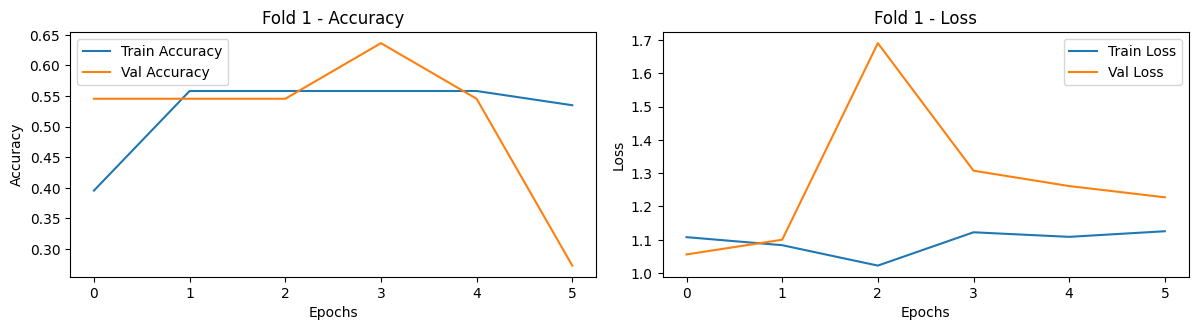

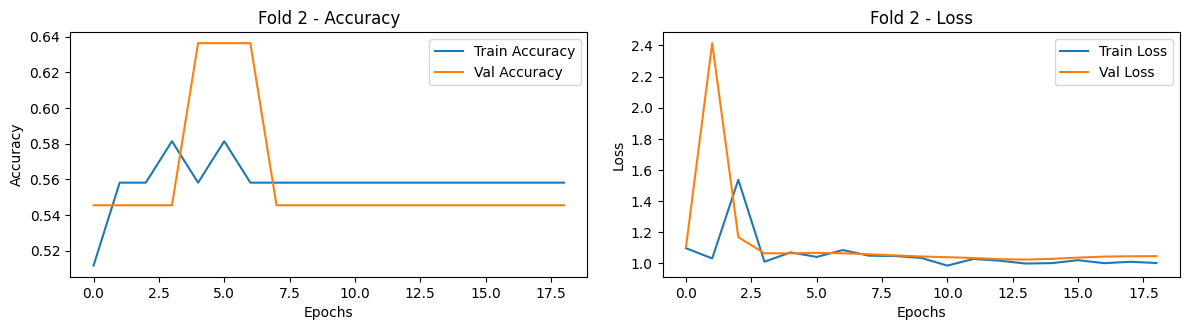

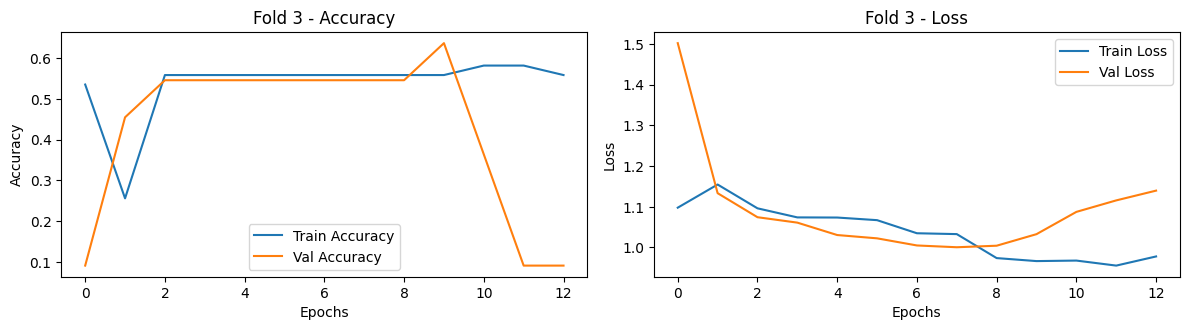

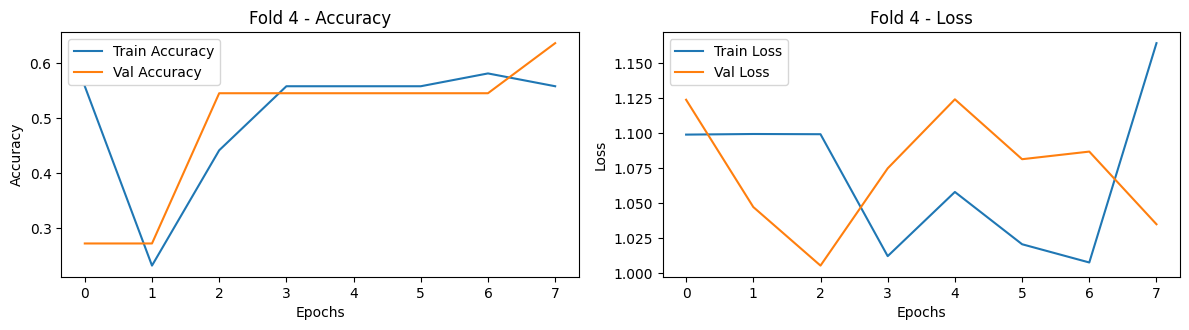

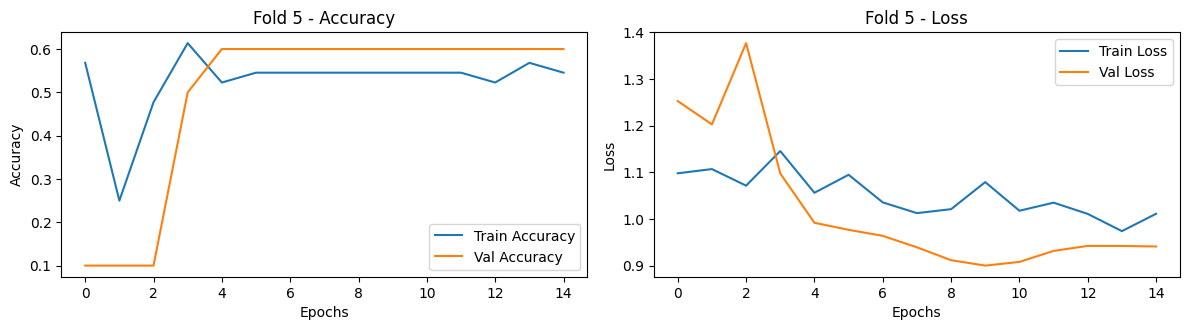

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define paths
base_dir = './autonomous-driving-dataset'
categories = ['Forward', 'Left', 'Right']

# Load images into memory
def load_images(base_dir, categories, img_size=(128, 128)):
    images = []
    labels = []
    for label, category in enumerate(categories):
        path = os.path.join(base_dir, category)
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess images
images, labels = load_images(base_dir, categories)

# Normalize images
images = images / 255.0

# One-hot encode labels
labels = to_categorical(labels, num_classes=len(categories))

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
history_list = []
val_accuracies = []

# Loop through each fold
for train_index, val_index in kf.split(images):
    print(f"Training Fold {fold}...")

    # Split data into training and validation sets for this fold
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Define the model with 5 CNN layers and increased complexity
    model = Sequential([
        # First Convolutional Layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),

        # Second Convolutional Layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Third Convolutional Layer
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Fourth Convolutional Layer
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Fifth Convolutional Layer
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten the output to feed into Dense layers
        Flatten(),

        # Fully connected layers
        Dense(256, activation='relu'),
        Dropout(0.5),

        # Output layer with 'softmax' for multi-class classification
        Dense(len(categories), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Data augmentation for image transformations
    datagen = ImageDataGenerator(
        rotation_range=15,  # Reduced rotation range
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,  # Reduced zoom range
        shear_range=0.2,
        brightness_range=[0.8, 1.05],  # Smaller brightness range
        horizontal_flip=True
    )

    # Callbacks for early stopping and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Fit the model on augmented data for this fold
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=64),  # Larger batch size
        validation_data=(X_val, y_val),
        epochs=50,  # More epochs for better convergence
        callbacks=[early_stop, reduce_lr]
    )

    # Save the history for this fold
    history_list.append(history)

    # Get validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)

    fold += 1

# Average validation accuracy across all folds
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

# Plotting each fold's results separately
for i, history in enumerate(history_list):
    # Create a new figure for each fold
    plt.figure(figsize=(12, 6))

    # Plot accuracy for the fold
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i+1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss for the fold
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# After training the model, save it as 'model.h5'
model.save('model.h5')